In [14]:
import numpy as np
from matplotlib import pyplot as plt
#from plot_parameters import FONT_SIZE, LEGEND_SIZE, FONT,  figsize
from noise_formulas import NEP_g, NEP_ph, S_I

figsize=(10,8)
#%run ../utils/python_utils.py
%run ../../plot_parameters.py

np.set_printoptions(precision=2)


In [3]:
# Read LiteBIRD detector parameters (reported on PTEP) from text file
v, dvfrac, popt, psat, tc, n  = np.loadtxt('LiteBIRD_PTEP_bolo_params.txt', skiprows=3, delimiter=',', dtype=float, usecols=(1,2,3,4,5,6), unpack=True)
dv = dvfrac*v
tb = 0.1

In [4]:
# calculate other noise sources
nep_g = NEP_g(psat, n, tb, tc) # phonon noise
nep_ph = NEP_ph(popt, v, dv) # photon noise

In [5]:
nep_read_req = np.sqrt((nep_g**2 + nep_ph**2)*(1.1**2-1))
rtes = np.array([1., 0.8, 0.7])
loopgain = 10
si = S_I(rtes[:, np.newaxis], psat-popt, loopgain)
nei_read_req = nep_read_req*si

In [15]:
print("NEPg [aW/sqrt(Hz)]")
print(nep_g*1e18)
print("NEP photon [aW/sqrt(Hz)]")
print(nep_ph*1e18)
print("NEP readout requirement [aW]/sqrt(Hz)")
print(nep_read_req*1e18)

NEPg [aW/sqrt(Hz)]
[4.37 4.   4.02 4.54 4.02 4.08 4.43 4.4  4.9  4.43 4.36 4.85 4.69 4.97
 4.54 5.15 4.71 6.46 5.09 5.68 4.53 3.94]
NEP photon [aW/sqrt(Hz)]
[ 6.35  6.07  6.45  6.74  6.24  6.79  7.09  7.46  9.06  7.28  7.63  9.53
  8.32  9.8  10.24  9.59  9.92 14.93 13.64 14.07 13.21 12.5 ]
NEP readout requirement [aW]/sqrt(Hz)
[3.53 3.33 3.48 3.72 3.4  3.63 3.83 3.97 4.72 3.9  4.03 4.9  4.37 5.04
 5.13 4.99 5.03 7.46 6.67 6.95 6.4  6.01]


In [17]:
for r, rt in enumerate(rtes):
    min_noise = np.min(nei_read_req[r, :])
    print("R: {:.2f}. Max noise: {:.2f} pA/sqrt(Hz)".format(rt, min_noise*1e12))

R: 1.00. Max noise: 6.20 pA/sqrt(Hz)
R: 0.80. Max noise: 6.93 pA/sqrt(Hz)
R: 0.70. Max noise: 7.41 pA/sqrt(Hz)


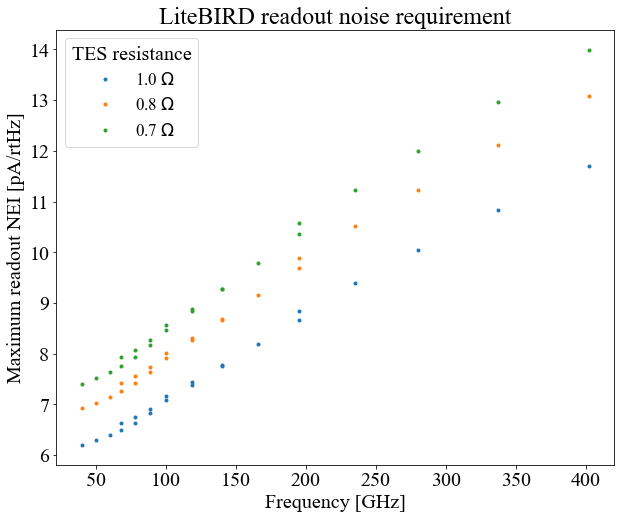

In [8]:
plt.figure(1, figsize=figsize)
plt.plot(v/1e9, nei_read_req[0]*1e12, '.', label=f'{rtes[0]} $\Omega$')
plt.plot(v/1e9, nei_read_req[1]*1e12, '.', label=f'{rtes[1]} $\Omega$')
plt.plot(v/1e9, nei_read_req[2]*1e12, '.', label=f'{rtes[2]} $\Omega$')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Maximum readout NEI [pA/rtHz]')
plt.title('LiteBIRD readout noise requirement')
plt.legend(title='TES resistance')
plt.show()

I don't think it makes a lot of sense to use the noise requirement at 1 ohm with loop gain at 10. Let's plot thing per Rfrac per loopgain

In [9]:
index = np.argmin(nei_read_req)
nep_read_max = nep_read_req[index]
N1 = 100
N2 = 50
r_tes_array = np.linspace(0.3, 1, N1)
loop_gain_array = np.linspace(0, 12, N2)

nei_read_max_matrix = np.empty((N1, N2))

for rc, r in enumerate(r_tes_array):
    
    for lgc, lg in enumerate(loop_gain_array):
        si = S_I(r, psat[index]-popt[index], lg)
        nei_read_max = nep_read_max*si
        
        nei_read_max_matrix[rc, lgc] = nei_read_max
        
        

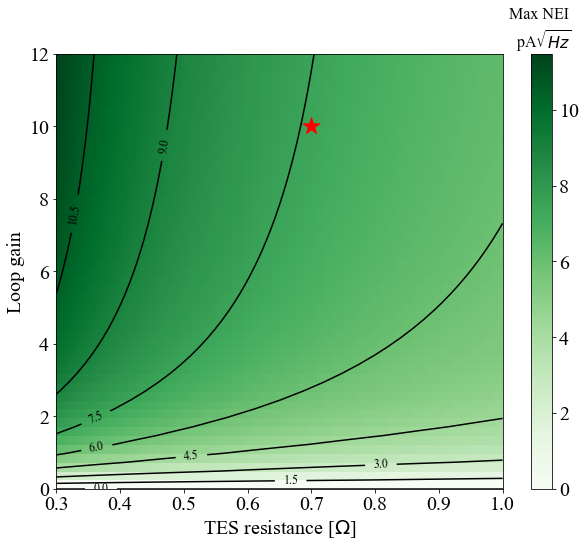

In [10]:
fig = plt.figure(12, figsize=figsize)

c = plt.pcolormesh( r_tes_array, loop_gain_array, np.transpose(nei_read_max_matrix*1e12), \
    cmap='Greens')

colorbar = fig.colorbar(c)
colorbar.ax.set_title('Max NEI \n pA$\sqrt{Hz}$', fontsize=16)
# add contours
contour = plt.contour(r_tes_array, loop_gain_array, np.transpose(nei_read_max_matrix*1e12), colors='black')
plt.clabel(contour, inline=True, fontsize=12, fmt='%2.1f')

plt.xlabel("TES resistance [$\\Omega$]")
plt.ylabel("Loop gain")

# point of interest
plt.scatter([0.7], [10], marker="*", s=300, color='red')


In [11]:
# But what is the noise at overbias?
V_overbiased = np.sqrt(psat[0])*1 # [V]
NEI_overbiased = nep_read_max / V_overbiased

print("Overbiased NEI: {:.1f} pA/sqrt(Hz)".format(NEI_overbiased*1e12))

Overbiased NEI: 3.7 pA/sqrt(Hz)


### See how this compares to achieved readout


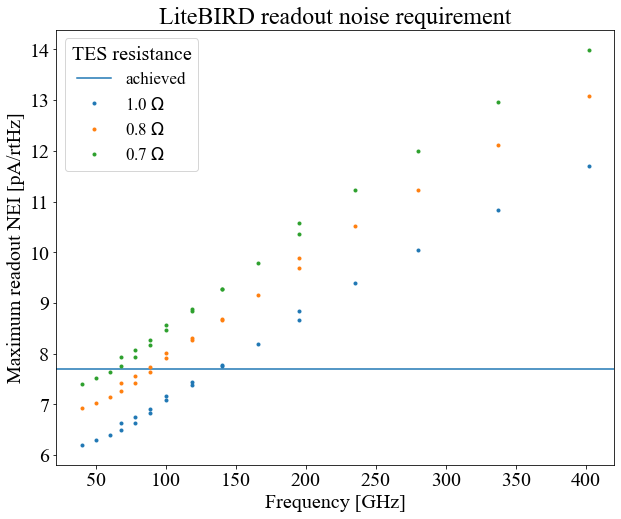

Rtes [ohms]    |    Achieved NEI / Min Required NEI 
   1.00        |               1.24  
   0.80        |               1.11  
   0.70        |               1.04  


In [12]:
# In terms of NEI
NEI_achieved = 7.7e-12 # A/sqrt(Hz) from an old presentation from Tucker

plt.figure(1, figsize=figsize)
plt.axhline(NEI_achieved*1e12, label="achieved")
plt.plot(v/1e9, nei_read_req[0]*1e12, '.', label=f'{rtes[0]} $\Omega$')
plt.plot(v/1e9, nei_read_req[1]*1e12, '.', label=f'{rtes[1]} $\Omega$')
plt.plot(v/1e9, nei_read_req[2]*1e12, '.', label=f'{rtes[2]} $\Omega$')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Maximum readout NEI [pA/rtHz]')
plt.title('LiteBIRD readout noise requirement')
plt.legend(title='TES resistance')
plt.show()


#print("Minimum NEI required: %.1f pA/sqrt(Hz) " %(np.min(nei_read_req[rc])*1e12 ))

print("Rtes [ohms]    |    Achieved NEI / Min Required NEI ")
for rc, r in enumerate(rtes):
    print("   %.2f        |               %.2f  " %(r, NEI_achieved / np.min(nei_read_req[rc])))

## In terms of NEP

In [13]:
#nep_read_req
#nei_read_req = nep_read_req*si

nep_read_achieved = NEI_achieved /(si[0]) # selecting resistance of 1 ohm and lowest frequency band
#print(nep_read_achieved)
#print("Responsivity: ", si[0][0])
yscale = 1 #  Watts

plt.figure(figsize=figsize)
plt.plot(v/1e9, nep_read_req*yscale, '.', label="required")
#plt.axhline( nep_read_achieved*yscale, label="achieved")
plt.plot( v/1e9, nep_read_achieved*yscale, '.', label="achieved")
plt.xlabel('Frequency [GHz]')
plt.ylabel('Maximum readout NEP [W/rtHz]')
plt.title('LiteBIRD readout noise requirement')
plt.legend()
plt.show()

IndexError: invalid index to scalar variable.